## Imports

In [1]:
%matplotlib widget

from os import path, chdir, getcwd, sep
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set project directory for imports.
my_project_path = path.normpath(Path(getcwd()).parent)
sys.path.insert(1,my_project_path)

from src.readers.basic_reader import BasicReader
from src.readers.paths import Paths
from src.visualization.graphs_static import Graphs
from src.processing.processing_methods import Preprocessor
from src.processing.format.data_wrapper_constants import DataFoldsConstants


CONSTANTS = DataFoldsConstants.spectro.ftir
_BOKEH = False

## Example analysis of spectra:
### Instrumental metchod: **Fourier Transfor Mid-Infrared Spectroscopy**
### Spectrometer: **MonitIR Fourier Transform infrared, Spectra-Tech Applied Systems Inc. (Stanford, CT)**
### Subject: **Wine**

### Data source and original document:

    Dataset source (repository):
    https://github.com/QIBChemometrics/Wine_Cabernet_Shiraz_FTIR
    
    Original document (DOI):
    10.1016/j.foodcont.2019.05.021
    https://www.sciencedirect.com/science/article/abs/pii/S0956713519302294?via%3Dihub
    
## Main goal
    


## **PART I** Data load & format conversion

Due to processing library requirements, at first data should be converted to desired format. In order to better understand the code and the symbols used, it is recommended to read the content of the following files:\
&ensp; /src/readers/**basic_reader.py**  --> file management,\
&ensp; /src/processing/format/constants/**constants_spectroscopy_ftir.py** --> structures used by the processing support system.

At this stage, we want to bring out as much information as possible and save the data in a format that is conducive to processing. This information will later be used to build a classification model:
-  the row names contain information about the wine type (in this case **Cabernet Sauvignon** and **Shiraz**),
-  and the sample number (**110 measurements** were made for **37 samples**). 


### 1st run: Initial data load and conversion to desired format 
Set **_FIRST_RUN** to **True**

### Next run: Load data in prepared format
Set **_FIRST_RUN** to **False**


In [2]:
_FIRST_RUN = False

if _FIRST_RUN:
    # Set files directory
    datasets_raw_url = "https://raw.githubusercontent.com/QIBChemometrics/Wine_Cabernet_Shiraz_FTIR/main/Wine_FTIR_Triplicate_Spectra.csv"
    dir_datasets_processed = path.join(Paths.DATASETS.get("processed"), "wine_ftir_spectra.pkl")

    # Load raw data, this time we use the file downloaded from a repository (link at the top of the notebook) 
    config_load = {
        "source": "url",
        "url": datasets_raw_url,
    }

    reader = BasicReader(
        load_data_on_init=True,
        configuration_load=config_load
    )
    dataset_raw = reader.data

    # Extract the x-axis of the spectrum, the set should contain only spectra and column labels
    axis_wavenumbers = dataset_raw.loc[:,"Wavenumbers"].values.tolist()
    dataset_raw = dataset_raw.drop("Wavenumbers", axis=1)

    # Expansion of abbreviations contained in column labels
    samples_full_names = {
        "Cab": "Cabernet Sauvignon",
        "Syr": "Shiraz"
    }

    # Expand the set with the information contained in the column labels
    dataset_processed = pd.DataFrame(columns=["Sample identificator", "Sample no", "Wine type", "Ingroup no", CONSTANTS.X_WAVENUMBER, CONSTANTS.Y_SPECTRUM])
    for sample in dataset_raw.columns[1:]:
        sample_identificator = sample.split("_")
        spectrum = dataset_raw.loc[:,sample].values.tolist()
        sample_dict = ({
            "Sample identificator": sample,
            "Sample no": int(sample_identificator[1]),
            "Wine type": samples_full_names.get(sample_identificator[2]),
            "Ingroup no": int(sample_identificator[3].replace("Rep","")),
            CONSTANTS.X_WAVENUMBER: [axis_wavenumbers],
            CONSTANTS.Y_SPECTRUM: [spectrum],
        })
        dataset_processed = pd.concat([dataset_processed, pd.DataFrame(sample_dict)])
    dataset_processed.reset_index(drop=True, inplace = True)
    
    # Save as file
    dataset_raw = {"fold0": dataset_processed}

    reader.configuration_save = {
        "dir": path.join(Paths.DATASETS.get("processed"), "ftir_spectra"),
        "file_name": "wine_ftir_spectra_prepared",
    }



else:
    config_load = {
        "source": "file",
        "dir": path.join(Paths.DATASETS.get("processed"), "ftir_spectra"),
        "file_name": "wine_ftir_spectra_prepared.pkl"
    }

    reader = BasicReader(
        load_data_on_init=True,
        configuration_load=config_load
    )
    dataset_raw = reader.data
    
dataset = pd.DataFrame(dataset_raw.get("fold0"))
dataset

,Sample identificator,Sample no,Wine type,Ingroup no,axis_wavenumber,spectra
0,Wine_01_Cab_Rep2,1,Cabernet Sauvignon,2,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.93968839, 0.90973724, 0.88272279, 0.8570789..."
1,Wine_01_Cab_Rep3,1,Cabernet Sauvignon,3,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.94107948, 0.91113522, 0.88382338, 0.8582939..."
2,Wine_02_Cab_Rep1,2,Cabernet Sauvignon,1,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.93791138, 0.90756022, 0.8805075, 0.8553392,..."
3,Wine_02_Cab_Rep2,2,Cabernet Sauvignon,2,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.94018023, 0.90998422, 0.88261225, 0.8574579..."
4,Wine_02_Cab_Rep3,2,Cabernet Sauvignon,3,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.94076432, 0.91051094, 0.88302139, 0.8578815..."
...,...,...,...,...,...,...
105,Wine_36_Syr_Rep2,36,Shiraz,2,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.92104587, 0.89139457, 0.865085, 0.84095178,..."
106,Wine_36_Syr_Rep3,36,Shiraz,3,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.91948947, 0.89024916, 0.86502439, 0.8409791..."
107,Wine_37_Syr_Rep1,37,Shiraz,1,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.92209085, 0.89264628, 0.86619204, 0.8421394..."
108,Wine_37_Syr_Rep2,37,Shiraz,2,"[899.327, 903.187, 907.047, 910.907, 914.767, ...","[0.92554666, 0.89641142, 0.86987365, 0.8452809..."


### First look into the dataset

Most diagrams are prepared using both the matplotlib and Bokeh libraries. Unfortunately, **Bokeh does not support inline display in GitHub notebook previews**. To enable preview without pulling the project, I decided to create charts also using the matplotlib libraries. To switch the API from matplotlib to Bokeh, set the global variable **_BOKEH** to **True**.

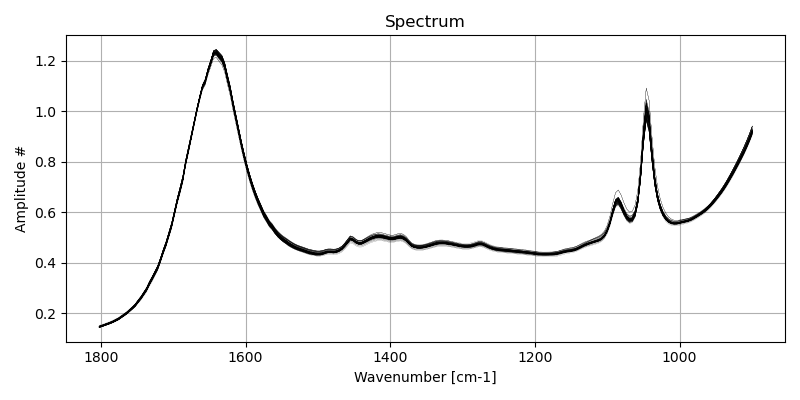

In [3]:

if _BOKEH:
    from bokeh.plotting import figure, output_notebook, show
    from bokeh.models import ColumnDataSource
    from bokeh.palettes import Dark2_5 as palette
    import itertools
    
    title = "Wine spectra - click on legend to hide gorup"
    fig = figure(plot_width=900, plot_height=400, title=title, x_axis_label="Wavenumber [cm-1]", y_axis_label="Amplitude #")
    colors = itertools.cycle(palette)
    for fold_name, fold_data in dataset_raw.items():
        wine_types = fold_data["Wine type"].unique()
        for wine in wine_types:
            _fold_filtered = fold_data[fold_data["Wine type"]==wine]
            _x_axis_filtered = list(_fold_filtered[CONSTANTS.X_WAVENUMBER])
            _spectra_filtered = list(_fold_filtered[CONSTANTS.Y_SPECTRUM])
            _color=next(colors)
            for idx, _spectrum in enumerate(_spectra_filtered):
                fig.line(x=_x_axis_filtered[idx], y=_spectrum, legend_label=wine, line_width=0.2, color=_color)
            
    fig.x_range.flipped = True  
    fig.legend.location = "bottom_right"
    fig.legend.click_policy="hide"

    output_notebook()
    show(fig)
else:
    for fold_name, fold_data in dataset_raw.items():
        _fig, _ax = Graphs.spectral.spectra(
            x_axis=fold_data.get(CONSTANTS.X_WAVENUMBER),
            y_spectra=fold_data.get(CONSTANTS.Y_SPECTRUM),
            label_x="Wavenumber [cm-1]"
        )
        _ax.invert_xaxis()

## **Part II** Basic preprocessing

### Preprocessing: data normalization (min-max method)

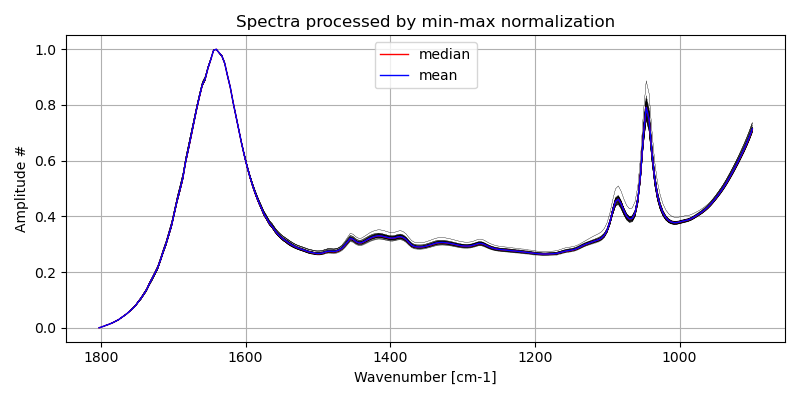

In [4]:
from sklearn import preprocessing
from src.processing.processing_methods import Baseline, Smooth

x_axis = np.array([axis for axis in dataset.get(CONSTANTS.X_WAVENUMBER)])
spectra = np.array([spectrum for spectrum in dataset.get(CONSTANTS.Y_SPECTRUM)])

spectra_norm_minmax = preprocessing.minmax_scale(spectra.T).T
spectra_median = np.median(spectra_norm_minmax, axis=0)
spectra_mean = np.mean(spectra_norm_minmax, axis=0)

fig, ax = Graphs.spectral.spectra(
    x_axis=x_axis,
    y_spectra=spectra_norm_minmax,
    label_x="Wavenumber [cm-1]",
    title="Spectra processed by min-max normalization"
)
ax.plot(x_axis[0], spectra_median, "-", color="r", linewidth=1, label="median")
ax.plot(x_axis[0], spectra_mean, "-", color="b", linewidth=1, label="mean")
ax.legend(loc="upper center")
ax.invert_xaxis()

### Preprocessing: data normalization (SNV method)

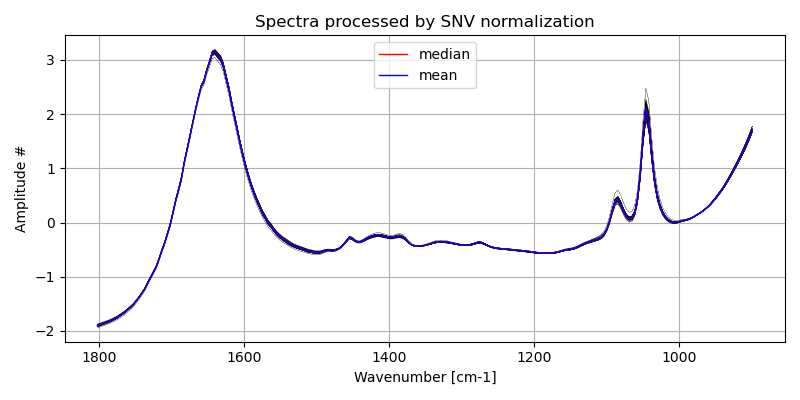

In [5]:
def normalize_snv(spectrum):
    return (spectrum[:] - np.mean(spectrum[:])) / np.std(spectrum[:])

spectra_norm_snv = [normalize_snv(spectrum) for spectrum in spectra] 
spectra_median = np.median(spectra_norm_snv, axis=0)
spectra_mean = np.mean(spectra_norm_snv, axis=0)

fig, ax = Graphs.spectral.spectra(
    x_axis=x_axis,
    y_spectra=spectra_norm_snv,
    label_x="Wavenumber [cm-1]",
    title="Spectra processed by SNV normalization"
)
ax.plot(x_axis[0], spectra_median, "-", color="r", linewidth=1, label="median")
ax.plot(x_axis[0], spectra_mean, "-", color="b", linewidth=1, label="mean")
ax.legend(loc="upper center")
ax.invert_xaxis()

### Preprocessing: baseline removal (ALS method)

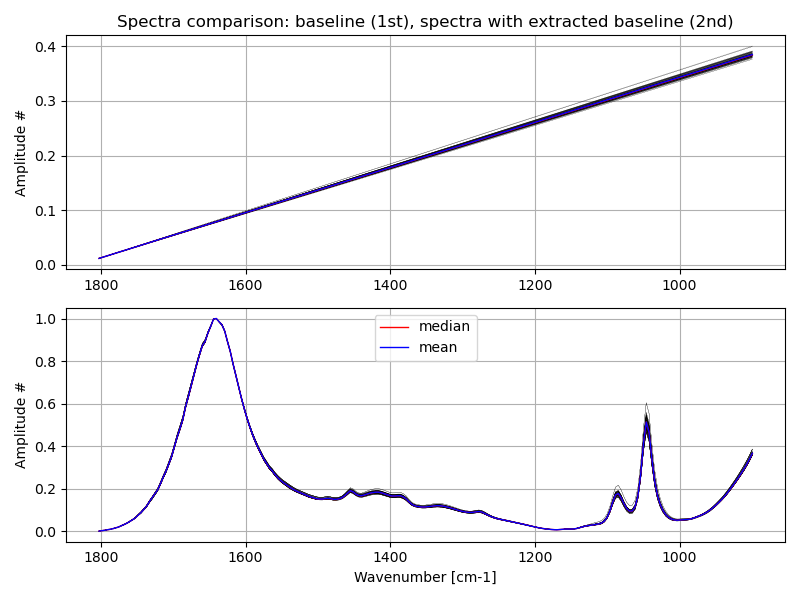

In [6]:
_output = "both"
_lam_pow = 7
_lam = 10**_lam_pow
_p = 0.002
_niter = 10

spectra_pack = [Baseline.als_optimized(output=_output, lam=_lam, p=_p, niter=_niter,
    y=spectrum) for spectrum in spectra_norm_minmax]
spectra_removal = np.vstack([spectrum_tuple[0] for spectrum_tuple in spectra_pack])
spectra_baseline = np.vstack([spectrum_tuple[1] for spectrum_tuple in spectra_pack])

spectra_median = np.median(spectra_norm_minmax, axis=0)
spectra_mean = np.mean(spectra_norm_minmax, axis=0)
spectra_median_removal, spectra_median_baseline = Baseline.als_optimized(output=_output, lam=_lam, p=_p, niter=_niter,
    y=spectra_median)
spectra_mean_removal, spectra_mean_baseline = Baseline.als_optimized(output=_output, lam=_lam, p=_p, niter=_niter,
    y=spectra_mean)

spectra_removal = preprocessing.minmax_scale(spectra_removal.T).T
spectra_median_removal = np.median(spectra_removal, axis=0)
spectra_mean_removal = np.mean(spectra_removal, axis=0)

fig,ax = Graphs.spectral.spectra_comparison(
    x1_axis = x_axis,
    x2_axis = x_axis,
    y1_spectra = spectra_baseline,
    y2_spectra = spectra_removal,
    label_x="Wavenumber [cm-1]",
    title="Spectra comparison: baseline (1st), spectra with extracted baseline (2nd)"
)
ax[0].plot(x_axis[0], spectra_median_baseline, "-", color="r", linewidth=1)
ax[0].plot(x_axis[0], spectra_mean_baseline, "-", color="b", linewidth=1)
ax[1].plot(x_axis[0], spectra_median_removal, "-", color="r", linewidth=1, label="median")
ax[1].plot(x_axis[0], spectra_mean_removal, "-", color="b", linewidth=1, label="mean")
ax[1].legend(loc="upper center")
ax[0].invert_xaxis()
ax[1].invert_xaxis()

### Preprocessing: smoothing and obtaining 2nd derivative (Foureir method)

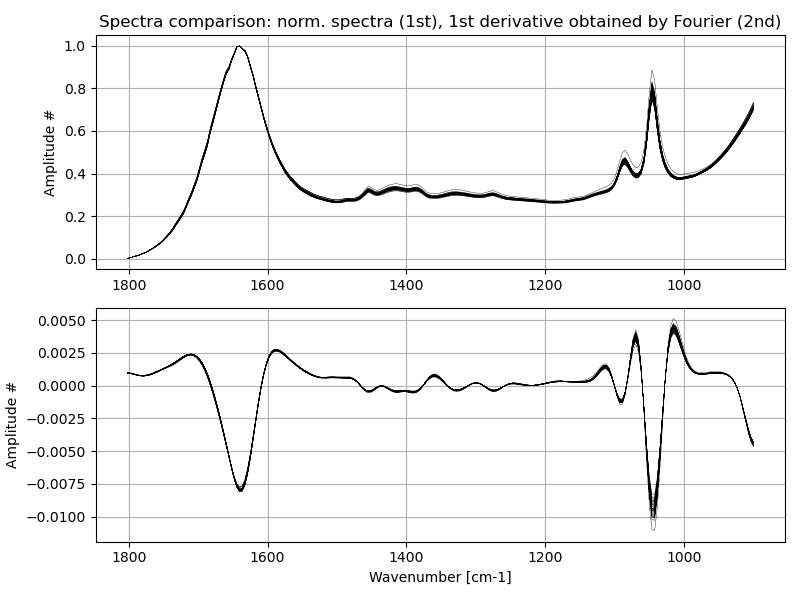

In [7]:
#Fourier smoothing filter with 2nd derivative
_sigma = 40
_m = 1
_derivative = True

spectra_first_deriv_fourier = [Smooth.fourier(sigma=_sigma, m=_m, derivative=_derivative, 
                                                y=spectrum) for spectrum in spectra_norm_minmax]

fig,ax = Graphs.spectral.spectra_comparison(
    x1_axis = x_axis,
    x2_axis = x_axis,
    y1_spectra = spectra_norm_minmax,
    y2_spectra = spectra_first_deriv_fourier,
    label_x="Wavenumber [cm-1]",
    title="Spectra comparison: norm. spectra (1st), 2nd derivative obtained by Fourier (2nd)"
)
ax[0].invert_xaxis()
ax[1].invert_xaxis()

### Preprocessing: smoothing and obtaining 2nd derivative (Sav-Gol method)

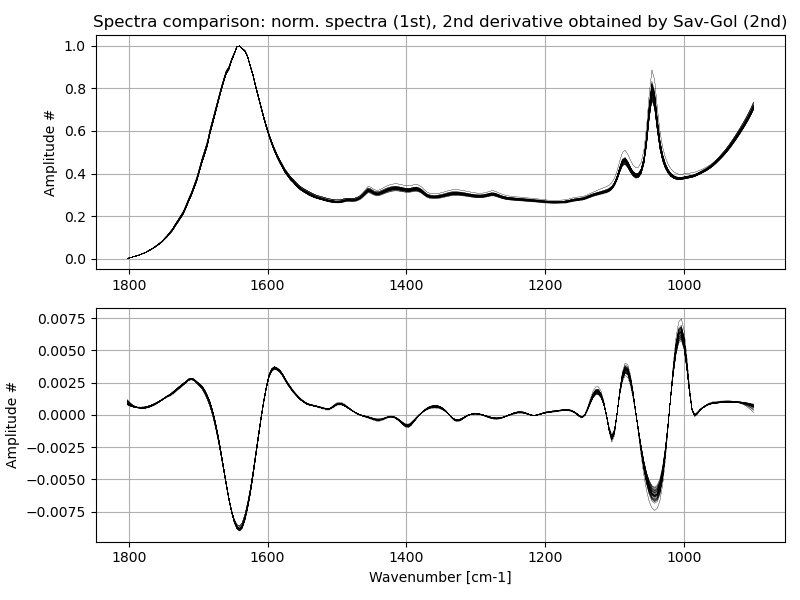

In [8]:
#Sav-Gol smoothing filter with 2nd derivative
_window_length = 31
_polyorder = 5
_derivative = 2

spectra_second_deriv_savgol = [Smooth.sav_gol(window_length=_window_length, polyorder=_polyorder, derivative=_derivative,
                                                y=spectrum) for spectrum in spectra_norm_minmax]

fig,ax = Graphs.spectral.spectra_comparison(
    x1_axis = x_axis,
    x2_axis = x_axis,
    y1_spectra = spectra_norm_minmax,
    y2_spectra = spectra_second_deriv_savgol,
    label_x="Wavenumber [cm-1]",
    title="Spectra comparison: norm. spectra (1st), 2nd derivative obtained by Sav-Gol (2nd)"
)
ax[0].invert_xaxis()
ax[1].invert_xaxis()

## PCA - Preprocessing effect comparison

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA as pca
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

pca_components_no = 20
pca1 = pca(n_components=pca_components_no)
pca2 = pca(n_components=pca_components_no)
pca3 = pca(n_components=pca_components_no)
pca4 = pca(n_components=pca_components_no)
pca5 = pca(n_components=pca_components_no)
pca6 = pca(n_components=pca_components_no)

nfeat1 = StandardScaler().fit_transform(spectra)
nfeat2 = StandardScaler().fit_transform(spectra_norm_minmax)
nfeat3 = StandardScaler().fit_transform(spectra_norm_snv)
nfeat4 = StandardScaler().fit_transform(spectra_removal)
nfeat5 = StandardScaler().fit_transform(spectra_first_deriv_fourier)
nfeat6 = StandardScaler().fit_transform(spectra_second_deriv_savgol)

X1 = pca1.fit(nfeat1)
expl_var_1 = X1.explained_variance_ratio_
X2 = pca2.fit(nfeat2)
expl_var_2 = X2.explained_variance_ratio_
X3 = pca3.fit(nfeat3)
expl_var_3 = X3.explained_variance_ratio_
X4 = pca4.fit(nfeat4)
expl_var_4 = X4.explained_variance_ratio_
X5 = pca5.fit(nfeat5)
expl_var_5 = X5.explained_variance_ratio_
X6 = pca6.fit(nfeat6)
expl_var_6 = X6.explained_variance_ratio_


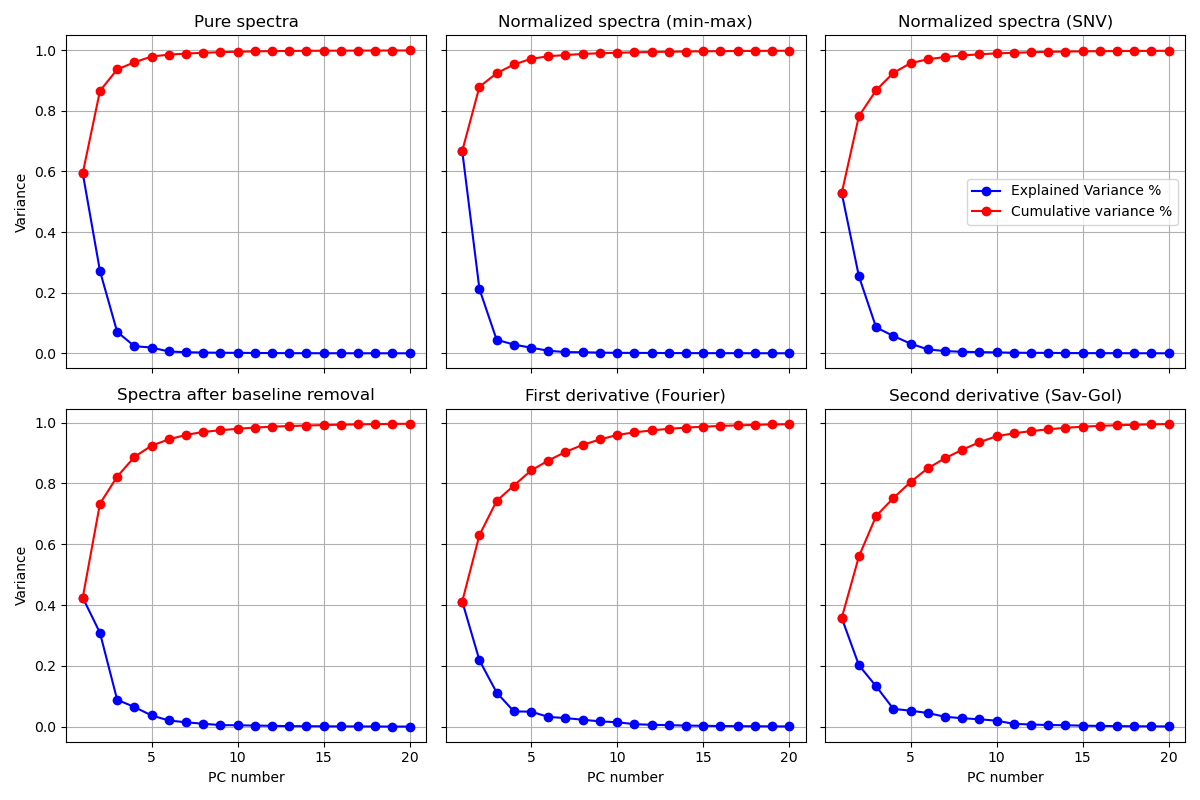

In [10]:

import itertools

pc_array = np.linspace(1,pca_components_no,pca_components_no)

if _BOKEH:
    from bokeh.plotting import figure, output_notebook, show
    from bokeh.layouts import row, gridplot
    from bokeh.models import ColumnDataSource
    from bokeh.palettes import Dark2_5 as palette
    
    sfig1 = figure(plot_width=300, plot_height=300, title="Pure spectra", y_axis_label="Variance")
    colors = itertools.cycle(palette)
    color=next(colors)
    sfig1.line(x=pc_array, y=expl_var_1, color=color)
    sfig1.circle(x=pc_array, y=expl_var_1, color=color)
    color=next(colors)
    sfig1.line(x=pc_array, y=np.cumsum(expl_var_1), color=color)
    sfig1.circle(x=pc_array, y=np.cumsum(expl_var_1), color=color)

    sfig2 = figure(plot_width=300, plot_height=300, title="Normalized spectra (min-max)")
    colors = itertools.cycle(palette)
    color=next(colors)
    sfig2.line(x=pc_array, y=expl_var_2, color=color, legend_label="Explained Variance %")
    sfig2.circle(x=pc_array, y=expl_var_2, color=color, legend_label="Explained Variance %")
    color=next(colors)
    sfig2.line(x=pc_array, y=np.cumsum(expl_var_2), color=color, legend_label="Cumulative variance %")
    sfig2.circle(x=pc_array, y=np.cumsum(expl_var_2), color=color, legend_label="Cumulative variance %")
    
    sfig3 = figure(plot_width=300, plot_height=300, title="Normalized spectra (SNV)")
    colors = itertools.cycle(palette)
    color=next(colors)
    sfig3.line(x=pc_array, y=expl_var_3, color=color, legend_label="Explained Variance %")
    sfig3.circle(x=pc_array, y=expl_var_3, color=color, legend_label="Explained Variance %")
    color=next(colors)
    sfig3.line(x=pc_array, y=np.cumsum(expl_var_3), color=color, legend_label="Cumulative variance %")
    sfig3.circle(x=pc_array, y=np.cumsum(expl_var_3), color=color, legend_label="Cumulative variance %")

    sfig3.legend.location = "center_right"

    sfig4 = figure(plot_width=300, plot_height=300, title="Spectra after baseline removal", x_axis_label="PC number", y_axis_label="Variance")
    colors = itertools.cycle(palette)
    color=next(colors)
    sfig4.line(x=pc_array, y=expl_var_4, color=color)
    sfig4.circle(x=pc_array, y=expl_var_4, color=color)
    color=next(colors)
    sfig4.line(x=pc_array, y=np.cumsum(expl_var_4), color=color)
    sfig4.circle(x=pc_array, y=np.cumsum(expl_var_4), color=color)

    sfig5 = figure(plot_width=300, plot_height=300, title="First derivative (Fourier)", x_axis_label="PC number")
    colors = itertools.cycle(palette)
    color=next(colors)
    sfig5.line(x=pc_array, y=expl_var_5, color=color)
    sfig5.circle(x=pc_array, y=expl_var_5, color=color)
    color=next(colors)
    sfig5.line(x=pc_array, y=np.cumsum(expl_var_5), color=color)
    sfig5.circle(x=pc_array, y=np.cumsum(expl_var_5), color=color)
    
    sfig6 = figure(plot_width=300, plot_height=300, title="Second derivative (Sav-Gol)", x_axis_label="PC number")
    colors = itertools.cycle(palette)
    color=next(colors)
    sfig6.line(x=pc_array, y=expl_var_6, color=color)
    sfig6.circle(x=pc_array, y=expl_var_6, color=color)
    color=next(colors)
    sfig6.line(x=pc_array, y=np.cumsum(expl_var_6), color=color)
    sfig6.circle(x=pc_array, y=np.cumsum(expl_var_6), color=color)

    output_notebook()
    show(gridplot([[sfig1, sfig2, sfig3], [sfig3, sfig4, sfig6]]), notebook_handle=True)
    
else:
    fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex='col', sharey='row')
    
    ax[0,0].plot(pc_array, expl_var_1, "-o", color="b")
    ax[0,0].plot(pc_array, np.cumsum(expl_var_1), "-o", color="r")
    ax[0,0].set(
        ylabel="Variance",
        title="Pure spectra",
    )
    
    ax[0,1].plot(pc_array, expl_var_2, "-o", color="b")
    ax[0,1].plot(pc_array, np.cumsum(expl_var_2), "-o", color="r")
    ax[0,1].set(
        title="Normalized spectra (min-max)",
    )
    
    ax[0,2].plot(pc_array, expl_var_3, "-o", color="b", label="Explained Variance %")
    ax[0,2].plot(pc_array, np.cumsum(expl_var_3), "-o", color="r", label="Cumulative variance %")
    ax[0,2].legend(loc="center right")
    ax[0,2].set(
        title="Normalized spectra (SNV)",
    )
        
    
    ax[1,0].plot(pc_array, expl_var_4, "-o", color="b")
    ax[1,0].plot(pc_array, np.cumsum(expl_var_4), "-o", color="r")
    ax[1,0].set(
        xlabel="PC number",
        ylabel="Variance",
        title="Spectra after baseline removal",
    )
    
    ax[1,1].plot(pc_array, expl_var_5, "-o", color="b")
    ax[1,1].plot(pc_array, np.cumsum(expl_var_5), "-o", color="r")
    ax[1,1].set(
        xlabel="PC number",
        title="First derivative (Fourier)",
    )
    
    ax[1,2].plot(pc_array, expl_var_6, "-o", color="b")
    ax[1,2].plot(pc_array, np.cumsum(expl_var_6), "-o", color="r")
    ax[1,2].set(
        xlabel="PC number",
        title="Second derivative (Sav-Gol)",
    )
    
    for ax1_idx in range(0, 2):
        for ax2_idx in range(0, 3):
            ax[ax1_idx, ax2_idx].grid()
    fig.tight_layout()
        

In [11]:
processing_used = ["Raw", "Norm. Min-Max", "Norm. SNV", "Baseline Removal", "2nd Deriv. Fourier", "2nd Deriv. Sav-Gol"]
index_expl = ["Cum. Var. for 2 PCA Comp.","Cum. Var. for 3 PCA Comp.","Cum. Var. for 5 PCA Comp.", "Components no. for 95%","Components no. for 99%"]

expl_variances = [expl_var_1,expl_var_2,expl_var_3,expl_var_4,expl_var_5,expl_var_6] 
cumulated_variances = [np.cumsum(expl_var) for expl_var in expl_variances]

var_value_for_2_components = [round(cum_var[2], 3) for cum_var in cumulated_variances]
var_value_for_3_components = [round(cum_var[3], 3) for cum_var in cumulated_variances]
var_value_for_5_components = [round(cum_var[5], 3) for cum_var in cumulated_variances]

def first_component_no_by_minimal_variance(cumulated_variances: list, cumulated_variances_required: float = 0.95):
    for _idx, _cum_var in enumerate(cumulated_variances):
        if _cum_var >= cumulated_variances_required:
            return _idx
    return _idx

var_comp_no_for_95_var = [first_component_no_by_minimal_variance(cum_var, 0.95) for cum_var in cumulated_variances]
var_comp_no_for_99_var = [first_component_no_by_minimal_variance(cum_var, 0.99) for cum_var in cumulated_variances]

processing_result_pca_stats = {
    index_expl[0]: var_value_for_2_components,
    index_expl[1]: var_value_for_3_components,
    index_expl[2]: var_value_for_5_components,
    index_expl[3]: var_comp_no_for_95_var,
    index_expl[4]: var_comp_no_for_99_var,
}
processing_result_pca_stats = pd.DataFrame(processing_result_pca_stats, index=processing_used)
processing_result_pca_stats

,Cum. Var. for 2 PCA Comp.,Cum. Var. for 3 PCA Comp.,Cum. Var. for 5 PCA Comp.,Components no. for 95%,Components no. for 99%
Raw,0.937,0.960,0.985,3,7
Norm. Min-Max,0.924,0.953,0.980,3,8
Norm. SNV,0.868,0.925,0.970,4,10
Baseline Removal,0.822,0.887,0.945,6,13
1st Deriv. Fourier,0.742,0.793,0.875,9,16
2nd Deriv. Sav-Gol,0.693,0.752,0.850,9,16


### Conclusion

The data description does not provide information about the equipment and how the spectra were obtained. The base article also lacks clear information about the equipment and methods used. However, as we can see, the processing methods used only worsen the final results. This means that the data has probably been preprocessed:
- the data is not an interferogram (FT digital or optical conversion),
- no visible noise (smoothed signal),
- no visible beginning and end of the signal in relation to the filters used (small wavenumber range, baseline difficult to reproduce without a broader context or calibration samples).

The spectra were probably obtained using a commercial solution. The raw signal has been calibrated, preprocessed and trimmed, so there is no need for additional processing.

## PCA - Classification

In [12]:
from sklearn.model_selection import KFold

X = spectra.tolist()
y = dataset["Wine type"].to_list()



y_uniques = ["Cabernet Sauvignon","Shiraz"]


dataset_spectra
# pca_95_components = 3

# model_pca = pca(n_components=pca_95_components)

NameError: name 'dataset_spectra' is not defined